dataset  
- amazon review
http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz

- chABSA
https://github.com/chakki-works/chABSA-dataset


https://github.com/ShopRunner/jupyter-notify
```
pip install jupyternotify
```

In [1]:
import tensorflow as tf
import numpy as np
import re
import os
import time
import datetime
from tensorflow.contrib.learn import preprocessing
import pickle
import pandas as pd
%matplotlib inline
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [30]:
class TextCNN:

    def __init__(
      self, sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):


        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        l2_loss = tf.constant(0.0)


        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            self.W = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W")
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

 
        outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(self.embedded_chars_expanded,W,strides=[1, 1, 1, 1],padding="VALID", name="conv")
                bn_conv = self.batch_normalization(conv) 
                h = tf.nn.relu(tf.nn.bias_add(bn_conv, b), name="relu")
                pooled = tf.nn.max_pool(h, ksize=[1, sequence_length - filter_size + 1, 1, 1],strides=[1, 1, 1, 1],padding='VALID',name="pool")
                dropped = tf.nn.dropout(pooled, self.dropout_keep_prob, name="dropout")
                outputs.append(dropped)


        num_filters_total = num_filters * len(filter_sizes)
        self.h = tf.concat(outputs, 3)
        self.h_flat = tf.reshape(self.h, [-1, num_filters_total])
        

        with tf.name_scope("fc-1"):
            W = tf.Variable(tf.truncated_normal([num_filters_total, 1024], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[1024]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            fc_1_output = tf.nn.relu(tf.nn.xw_plus_b(self.h_flat, W, b), name="fc-1-out")


        with tf.name_scope("dropout-1"):
            drop_1 = tf.nn.dropout(fc_1_output, self.dropout_keep_prob)


        with tf.name_scope("fc-2"):
            W = tf.Variable(tf.truncated_normal([1024,1024], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[1024]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            fc_2_output = tf.nn.relu(tf.nn.xw_plus_b(drop_1, W, b), name="fc-2-out")
            
        with tf.name_scope("dropout-2"):
            drop_2 = tf.nn.dropout(fc_2_output, self.dropout_keep_prob)


        with tf.name_scope("fc-3"):
            W = tf.Variable(tf.truncated_normal([1024, num_classes], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(drop_2, W, b, name="output")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")
            
            
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss


        with tf.name_scope("accuracy"):
            self.correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_predictions, "float"), name="accuracy") 
            
            
    def batch_normalization(self, x):
        """
          x -> γ(x-μ)/√（σ^2-ε）　+ β
      
          γ : scale
          μ: mean (first moment)
          σ: variance (second moment)
          β: offset
          ε: to avoid dividing by 0
        """
        epsilon = 1e-5
        dim = x.get_shape()[-1]
        scale = tf.Variable(tf.ones([dim]))
        offset = tf.Variable(tf.zeros([dim]))
        mean, variance = tf.nn.moments(x, [0,1,2])
        return tf.nn.batch_normalization(x, mean, variance, offset, scale, epsilon)

In [31]:
#positive_data_file = "data/amazon/book_pos.txt"
#negative_data_file = "data/amazon/book_neg.txt"

positive_data_file = "data/amazon_ja/pos.txt"
negative_data_file = "data/amazon_ja/neg.txt"

long_doc =True

#positive_data_file = "data/chABSA/pos.txt"
#negative_data_file = "data/chABSA/neg.txt"

In [32]:
def load_data_and_labels(positive_data_file, negative_data_file, level="char"):
       
    positive_examples = list(open(positive_data_file, "r").readlines())
    negative_examples = list(open(negative_data_file, "r").readlines())
    if level == "char":
        positive_examples = [s.replace(" ", "").replace("", " ").lower() for s in positive_examples]
        negative_examples = [s.replace(" ", "").replace("", " ").lower() for s in negative_examples]
    elif level == "word":
        positive_examples = [s.strip() for s in positive_examples]
        negative_examples = [s.strip() for s in negative_examples]
    else:
        print("invaid value of 'level'. ('char' or 'word') ")
        
    x_text = positive_examples + negative_examples

    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    
    return x_text, y

In [5]:
%%notify
x_text, y = load_data_and_labels(positive_data_file, negative_data_file)

<IPython.core.display.Javascript object>

In [6]:
len(x_text)

16995

In [7]:
x_text[0]

' p s 4 で の ボ イ ス チ ャ ッ ト 、 キ ャ プ チ ャ 用 途 で 購 入 し ま し た マ イ ク は 別 途 持 っ て い る の で u s b デ バ イ ス だ け が 欲 し か っ た ん で す が 、 安 い 割 に ま と も に 使 え ま す 付 属 の u s b デ バ イ ス の ア ナ ロ グ 出 力 の 品 質 に つ い て は 実 際 の s / n 比 も 悪 く な く ノ イ ズ は 気 に な ら な い レ ベ ル で す 以 下 、 ケ ー ブ ル で 外 部 ミ キ サ ー と 接 続 し て い ま す ↓ マ イ ク の 入 力 用 h o s a c m p - 1 0 3 9 1 c m ス テ レ オ ミ ニ プ ラ グ - モ ノ ラ ル フ ォ ン プ ラ グ オ ー デ ィ オ ケ ー ブ ル ↓ 出 力 用 s i l k r o a d y c b - 1 1 5 - 1 . 5 ス テ レ オ ミ ニ プ ラ グ - 1 / 4 フ ォ ン オ ー デ ィ オ ケ ー ブ ル 1 . 5 m 以 上 、 総 じ て 満 足 の い く 買 い 物 で し た p s 4 で の 使 用 に つ い て も 書 き ま す 付 属 の u s b デ バ イ ス を 接 続 す る と ヘ ッ ド セ ッ ト の 扱 い に な り ま す ＜ 接 続 時 ＞ \u3000 h d m i = シ ス テ ム 、 ゲ ー ム の 音 \u3000 u s b デ バ イ ス = チ ャ ッ ト 音 声 p s 4 本 体 を t v に h d m i で 接 続 し て い る 場 合 、 t v か ら は 相 手 の チ ャ ッ ト 音 声 が 聞 こ え ま せ ん u s b デ バ イ ス の 「 a u d i o o u t 」 に 出 力 さ れ る の で イ ヤ フ ォ ン を 挿 す こ と に な り ま す そ れ だ と チ ャ ッ ト 音 声 し か 聞 こ え ま せ ん が 、 p s 4 本 体 の 設 定 を 変 え る こ と で チ ャ ッ ト 音 声 、 シ ス テ ム 、 ゲ ー ム の 音 全 て を u s b デ バ 

In [8]:
length_list = np.array([len(r)for r in x_text])

In [9]:
df = pd.DataFrame(length_list, columns=["length"])
df.head()

,length
0,1339
1,533
2,321
3,183
4,153


In [10]:
df.describe(percentiles=[0.5,0.75,0.8,0.9])

,length
count,16995.000000
mean,288.150809
std,425.152913
min,27.000000
50%,193.000000
75%,323.000000
80%,373.000000
90%,531.000000
max,17495.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1f1d4e80>]],
      dtype=object)

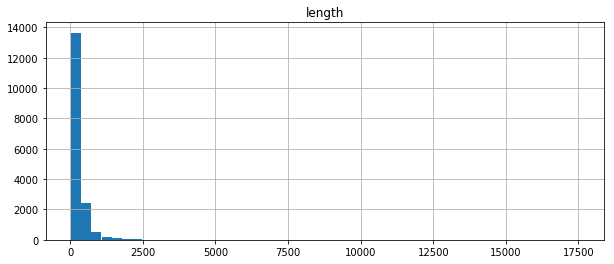

In [11]:
df.hist(bins=50,figsize=(10,4))

In [12]:
#max_length = 1000
max_length = 400
if long_doc:
    x_text = [x[:max_length] if len(x) > max_length else x for x in x_text]
length_list = np.array([len(r)for r in x_text])
df = pd.DataFrame(length_list, columns=["length"])
df.describe(percentiles=[0.5,0.75,0.8,0.9])

,length
count,16995.000000
mean,218.608650
std,117.271831
min,27.000000
50%,193.000000
75%,323.000000
80%,373.000000
90%,400.000000
max,400.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1efabcc0>]],
      dtype=object)

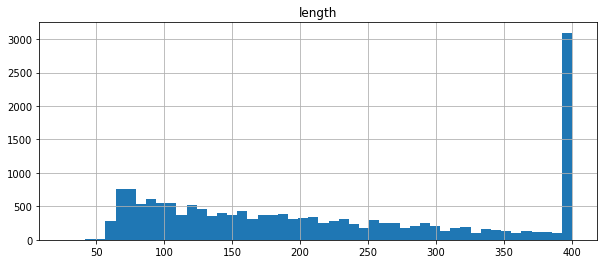

In [13]:
df.hist(bins=50,figsize=(10,4))

In [14]:
level = "char" #"word"

In [15]:
if level == "word":
    max_document_length = max([len(x.split(" ")) for x in x_text])
elif level == "char":
    max_document_length = max([len(x) for x in x_text])
print("max document length", max_document_length)

max document length 400


In [16]:
vocab_processor = preprocessing.VocabularyProcessor(max_document_length)

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [17]:
%%notify
x = np.array(list(vocab_processor.fit_transform(x_text)))

Instructions for updating:
Please use tensorflow/transform or tf.data.


<IPython.core.display.Javascript object>

In [18]:
test_percentage = 0.1#0.0010 #0.1

In [19]:
%%notify
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

test_sample_index = -1 * int(test_percentage * float(len(y)))
x_train, x_test = x_shuffled[:test_sample_index], x_shuffled[test_sample_index:]
y_train, y_test = y_shuffled[:test_sample_index], y_shuffled[test_sample_index:]

#del x, y, x_shuffled, y_shuffled

print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))

Vocabulary Size: 2612
Train/Test split: 15296/1699


<IPython.core.display.Javascript object>

In [20]:
print(x_train.shape)

(15296, 400)


In [21]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    print("num of epochs: ", num_epochs)
    print("num of batches: ", num_batches_per_epoch)
    print("num of step: ", num_batches_per_epoch*num_epochs)
    for epoch in range(num_epochs):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [22]:
sequence_length = x_train.shape[1]
num_classes = y_train.shape[1]
vocab_size = len(vocab_processor.vocabulary_)

In [37]:
embedding_size = 64     
filter_sizes = [2,3,4,5]    
num_filters=128               
dropout_keep_prob=0.5
l2_reg_lambda=0.1      

In [38]:
TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)

In [39]:
time_path = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
prefix = ""
out_dir = os.path.join(os.path.curdir, "runs", time_path, prefix)
print("Writing to {}\n".format(out_dir))

Writing to ./runs/2018_07_01_23_04_49/



In [40]:
batch_size = 64                  
num_epochs = 200            
evaluate_every = 20         
num_checkpoints = 5
learning_rate = 1e-3

allow_soft_placement = True    
log_device_placement = False  

save_checkpoint = True

In [ ]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=allow_soft_placement,
      log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    
    with sess.as_default():
        
        cnn = TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)


        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)


        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)


        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        test_summary_op = tf.summary.merge([loss_summary, acc_summary])
        test_summary_dir = os.path.join(out_dir, "summaries", "test")
        test_summary_writer = tf.summary.FileWriter(test_summary_dir, sess.graph)

        if save_checkpoint:
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

  
        vocab_processor.save(os.path.join(out_dir, "vocab"))


        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: dropout_keep_prob
            }
            _, step, summaries, loss, accuracy = sess.run([train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def test_step(x_batch, y_batch, writer=None):
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 1.0
            }
            predictions, step, summaries, loss, accuracy = sess.run([cnn.predictions, global_step, test_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            
            print(len(np.where(predictions==1)[0]))
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)

        batches = batch_iter(list(zip(x_train, y_train)), batch_size, num_epochs)
        for batch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            
            if current_step % evaluate_every == 0:
                print("\nEvaluation:")
                test_step(x_test, y_test, writer=test_summary_writer)
                print("")
                
            if save_checkpoint and current_step % evaluate_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/hist is illegal; using conv-maxpool-2/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/sparsity is illegal; using conv-maxpool-2/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/hist is illegal; using conv-maxpool-2/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/sparsity is illegal; using conv-maxpool-2/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/Variable:0/grad/hist is illegal; using conv-maxpool-2/Variable_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/Variable:0/grad/sparsity is illegal; using conv-maxpool-2/Variable_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/Vari

1699
2018-07-01T23:05:25.285332: step 40, loss 0.914057, acc 0.778693

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_01_23_04_49/checkpoints/model-40

2018-07-01T23:05:25.930062: step 41, loss 0.933815, acc 0.765625
2018-07-01T23:05:26.422086: step 42, loss 0.98784, acc 0.71875
2018-07-01T23:05:26.890102: step 43, loss 0.900427, acc 0.75
2018-07-01T23:05:27.354421: step 44, loss 0.818864, acc 0.84375
2018-07-01T23:05:27.836010: step 45, loss 0.86101, acc 0.78125
2018-07-01T23:05:28.265477: step 46, loss 0.863441, acc 0.78125
2018-07-01T23:05:28.723580: step 47, loss 0.86103, acc 0.765625
2018-07-01T23:05:29.187428: step 48, loss 0.793726, acc 0.796875
2018-07-01T23:05:29.661890: step 49, loss 0.836736, acc 0.765625
2018-07-01T23:05:30.152139: step 50, loss 0.730189, acc 0.828125
2018-07-01T23:05:30.597606: step 51, loss 0.84231, acc 0.765625
2018-07-01T23:05:31.073168: step 52, loss 0.825181, acc 0.75
2018-07-01T23:05:31.541015: step 53, loss 0.859846, ac

2018-07-01T23:06:40.333143: step 151, loss 0.535425, acc 0.8125
2018-07-01T23:06:40.835483: step 152, loss 0.514675, acc 0.8125
2018-07-01T23:06:41.429705: step 153, loss 0.722085, acc 0.6875
2018-07-01T23:06:42.007284: step 154, loss 0.509008, acc 0.8125
2018-07-01T23:06:42.523131: step 155, loss 0.604248, acc 0.734375
2018-07-01T23:06:43.030656: step 156, loss 0.536011, acc 0.8125
2018-07-01T23:06:43.526783: step 157, loss 0.619497, acc 0.75
2018-07-01T23:06:44.034936: step 158, loss 0.594269, acc 0.75
2018-07-01T23:06:44.583282: step 159, loss 0.535089, acc 0.828125
2018-07-01T23:06:45.111148: step 160, loss 0.545409, acc 0.796875

Evaluation:
1699
2018-07-01T23:06:48.951133: step 160, loss 0.556079, acc 0.778693

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_01_23_04_49/checkpoints/model-160

2018-07-01T23:06:49.711816: step 161, loss 0.572708, acc 0.75
2018-07-01T23:06:50.273185: step 162, loss 0.562833, acc 0.78125
2018-07-01T23:06:50.802612: step 1

char level cnn 
- 1525408577  
- 1526189751 chABSA  good
- 1523936751 amazon good

In [ ]:
def check_neg_posi(text):
    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
              allow_soft_placement=allow_soft_placement,
              log_device_placement=log_device_placement)
        sess = tf.Session(config=session_conf)
        vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join(out_dir, "vocab"))
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())
            saver.restore(sess, latest_ckpt)
        
            text = [s.replace(" ", "").replace("", " ").lower() for s in [text]]
            x = np.array(list(vocab_processor.fit_transform(text)))
            feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
            sess.run(tf.global_variables_initializer())
            feature_2 = sess.run(cnn.scores, feed_dict=feed_dict)
    print(feature_2[0])
    if np.argmax(feature_2[0]):
        print("positive")
    else:
        print("negative")

In [ ]:
check_neg_posi("伸び率は増加傾向にありました。")

In [ ]:
check_neg_posi("伸び率は減少傾向にありました。")

In [ ]:
check_neg_posi("伸び率は加向にありました。")

In [ ]:
check_neg_posi("伸び率は減向にありました。")

In [ ]:
out_dir="runs/1523936751"

In [ ]:
ckpt_dir = os.path.join(out_dir, "checkpoints" )
latest_ckpt = tf.train.get_checkpoint_state(ckpt_dir).model_checkpoint_path

In [ ]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
          allow_soft_placement=allow_soft_placement,
          log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join(out_dir, "vocab"))
    with sess.as_default():
        cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, latest_ckpt)
        #sess.run(tf.global_variables_initializer())
        w = sess.run(cnn.W, feed_dict={cnn.input_x: x_test})

In [ ]:
w

In [ ]:
w.shape

In [ ]:
with open('embedding_tensor.tsv','w') as f:
    for char_vec in w:
        for weight in char_vec:
            f.write(str(weight)+ "\t")
        f.write("\n")

In [ ]:
#vocab_dict = vocab_processor.vocabulary_._mapping
vocab_dict = vocab_processor.vocabulary_._reverse_mapping

In [ ]:
vocab_dict[1]

In [ ]:
with  open('embedding_metadata.tsv' ,'w') as f:
    f.write('Titles\tGenres\n')
    for i,v in enumerate(w):
        f.write("%s\t%s\n" % (vocab_dict[i], vocab_dict[i]))

In [ ]:
def get_feature(x):
    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
          allow_soft_placement=allow_soft_placement,
          log_device_placement=log_device_placement)
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_dim,
                filter_sizes=list(map(int, filter_sizes.split(","))),
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)

            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())

            saver.restore(sess, latest_ckpt)

            feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
            feature_5, feature_2 = sess.run([cnn.f_h, cnn.scores ], feed_dict=feed_dict)
    return feature_5, feature_2


In [ ]:
review = list(open("data/amazon/rating_5.txt", "r").readlines())
review = [s.strip() for s in review]

In [ ]:
y = []
x = []
for r in review:
    l = r.split(":::::")
    y.append(float(l[0]))
    x.append(l[1].replace(" ", "").replace("", " "))

In [ ]:
vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join("runs/1525408577", "vocab"))

In [ ]:
x[0]

In [ ]:
y[0]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x)))
y = np.array(y)

In [ ]:
len(x)

In [ ]:
feature_5 ,feature_2 = get_feature(x[:100])

In [ ]:
feature_5[0]

In [ ]:
feature_5[1]

In [ ]:
s = 0
chunk_size = 100
for i in range(0, len(x) , chunk_size):
    feature_5 ,feature_2 = get_feature(x[i:i+chunk_size])
    for f, r in zip(feature_5, y[i:i+chunk_size]):
        s  += int(np.argmax(f) == r)
    print(s/(i+chunk_size))
s

In [ ]:
np.argmax(feature_5)

In [ ]:
feature_2 [0]  #[neg, pos]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x_text)))